In [1]:
import os

# Change to the parent directory
os.chdir('../..')

# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


In [2]:
# import torch
# torch.cuda.is_available()

In [3]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

# Building a NARX Neural Network

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from src.file_loader import load_csv_files
# import matplotlib as mpl
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

In [5]:
# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


In [6]:
# List of file names
file_names = [
    '9171_20241001_N11507060127_ Rapid polarization-2.csv'
    ]

# print(f"Processing file: {file_names}")
dataframes = load_csv_files(file_names, '', 'deep learning assignment')


In [7]:
# Extract the DataFrame
data = dataframes['9171_20241001_N11507060127__Rapid_polarization-2_csv']

# Confirm it's a DataFrame
print(type(data))  # Should output <class 'pandas.core.frame.DataFrame'>

# Use the describe() method
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
       Time (HH:mm:ss.SSS) Channel     CH      V      A
count                16383   16341  16320  16320  16320
unique               16323   16321      2    142     16
top                   Step     CH1    CH1  2.926  2.251
freq                    21      21  16299   2120   5620


In [8]:
data.head()

,Time (HH:mm:ss.SSS),Channel,CH,V,A
0,11:45:54.513,0.780562,CH1,1.429,0.046
1,11:45:54.753,1.0206133,CH1,1.444,0.046
2,11:45:54.983,1.2505946,CH1,1.452,0.046
3,11:45:55.223,1.490689,CH1,1.457,0.046
4,11:45:55.453,1.7206743,CH1,1.461,0.046


In [9]:
data.dtypes

Time (HH:mm:ss.SSS)    object
Channel                object
CH                     object
V                      object
A                      object
dtype: object

In [10]:
# Convert `V` and `A` columns to numeric
data['V'] = pd.to_numeric(data['V'], errors='coerce')
data['A'] = pd.to_numeric(data['A'], errors='coerce')

In [11]:
# Drop rows with NaN values in these columns if conversion fails
data = data.dropna(subset=['V', 'A'])

In [12]:
# Select numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
numeric_data = data[numeric_cols]

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(numeric_data)

# Create a new DataFrame with scaled values
scaled_data = pd.DataFrame(scaled, columns=numeric_cols, index=data.index)

# # Optional: Combine with non-numeric columns
# non_numeric_cols = data.select_dtypes(exclude=['float64', 'int64'])
# final_data = pd.concat([non_numeric_cols, scaled_data], axis=1)

# # Check the result
# print(final_data.head())

scaled_data.head()


,V,A
0,0.000000,0.0
1,0.007637,0.0
2,0.011711,0.0
3,0.014257,0.0
4,0.016293,0.0


## **NARX Neural Network Model**

The NARX (Nonlinear Autoregressive with Exogenous Inputs) model is a type of recurrent neural network (RNN) designed to predict future values in a time-series dataset by using past values of the target variable (autoregressive terms) and past values of external (exogenous) variables. It is particularly useful when the relationship between the variables is nonlinear, which is common in real-world systems

---

The NARX model leverages both historical values of the target variable and additional exogenous inputs to make predictions. This dual input system makes it highly effective for modeling time-series data where both internal system dynamics and external influences are important.

Mathematically, the NARX model is expressed as:

\[
y(t) = f(y(t-1), y(t-2), ..., y(t-n), u(t-1), u(t-2), ..., u(t-m)) + e(t)
\]

Where:
- \(y(t)\): The target variable at time \(t\).
- \(y(t-1), y(t-2), ..., y(t-n)\): The autoregressive terms — previous values of the target variable, up to time 𝑡−𝑛.
- \(u(t-1), u(t-2), ..., u(t-m)\): The exogenous input terms — previous values of the independent or external variables, up to time t−m.
- \(e(t)\): The error term at time \(t\).
- \(f\): A nonlinear function, typically approximated using a neural network.

In this framework:
- **\(y\)**: Represents the target variable.
- **\(u\)**: The input sequence of past data that influence the target variable.
- **Neural Network**: The function 𝑓 is modeled using a neural network, which learns the nonlinear relationships between the autoregressive terms, exogenous inputs, and the target variable. This is what makes NARX different from traditional linear autoregressive models.
---


### 1. Using Feedforward neural network (FNN) Implementation

**Mathematical explanation for the sequence function**

The function `create_narxffn_sequences` creates overlapping sliding windows from the dataset:

- **Mathematics**:
  - For each window of size \(L\) (sequence length):
    - **Inputs**: \([x_{t-L}, x_{t-L+1}, ..., x_{t-1}]\)
    - **Target**: \(x_t\)

- The function also flattens the data for simpler input into the dense network.

---



In [13]:
def create_narxffn_sequences(input_data, target_column, sequence_length=1, flatten=False):
    """
    Generates sequences of input data and corresponding target labels from time-series data.

    This function slices the input data into subsequences of a specified length, where each subsequence 
    corresponds to a sequence of input features, and the target label is the value of the specified 
    target column at the point immediately following the subsequence.

    Parameters:
    ----------
    input_data : ndarray
        A 2D array or matrix containing the time-series data (with rows as time steps and columns as features).
        
    target_column : int
        The column index in the input data representing the target variable for which we are predicting.
        
    sequence_length : int, optional (default=1)
        The length of the sequence used as input for the prediction model.
        
    flatten : bool, optional (default=False)
        If True, flattens the input sequences into 1D arrays. If False, the sequences retain their original shape.

    Returns:
    -------
    np.ndarray, np.ndarray
        A tuple of two arrays:
        - The first array contains the input sequences, each of shape (sequence_length, features).
        - The second array contains the target labels corresponding to each sequence.

    Mathematical Explanation:
    -------------------------
    Let \( X_t \) represent the input data at time step \( t \), and \( Y_t \) represent the target value 
    at time step \( t \) from the column `target_column`. The function generates subsequences \( X_{t:t+L} \) 
    (where \( L \) is the `sequence_length`) and assigns the target value as \( Y_{t+L} \) (the value at the 
    next time step after the sequence). 

    The formula for generating the input-output pair is:
        Input sequence: \( X = [X_t, X_{t+1}, ..., X_{t+L-1}] \)
        Target value: \( Y = X_{t+L}[target_column] \)

    Example:
    --------
    input_data = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])
    target_column = 1
    sequences, labels = create_sequences(input_data, target_column, sequence_length=2)
    """
    inputs = []
    targets = []
    data_size = len(input_data)
    
    for i in range(data_size-sequence_length):
        sequence = input_data[i:i+sequence_length]
        #print(type(sequence))
        label_position = i + sequence_length
        label = input_data[label_position][target_column]
        if flatten:
            inputs.append(sequence.flatten())
        else:
            inputs.append(sequence)
        targets.append(label)
        
    return np.array(inputs), np.array(targets)


<>:2: SyntaxWarning: invalid escape sequence '\('
<>:2: SyntaxWarning: invalid escape sequence '\('
C:\Users\onyer\AppData\Local\Temp\ipykernel_20600\522390846.py:2: SyntaxWarning: invalid escape sequence '\('
  """


In [14]:
x, y = create_narxffn_sequences(scaled_data.to_numpy(), 1, 3, flatten=True)
x.shape, y.shape

((16296, 6), (16296,))

In [15]:
split_ratio = 0.25
split = int(len(x) * split_ratio)

x_train, x_valid = x[:-split], x[-split:]
y_train, y_valid = y[:-split], y[-split:]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")

x_train shape: (12222, 6), y_train shape: (12222,)
x_valid shape: (4074, 6), y_valid shape: (4074,)



## **NARXFFN (Nonlinear Autoregressive with Exogenous Inputs Feedforward Neural Network)**

The **NARXFFN** model is a simple feedforward neural network designed to predict future values based on past observations of both the target and exogenous variables. This model structure includes two layers:

### **Model Architecture**

```python
narxffn_model = keras.Sequential([
    layers.Dense(10, activation='tanh', input_shape=(x.shape[1],)),
    layers.Dense(1, activation='relu')
])
```

- **Input Layer**:
    - The input layer accepts a vector of size `x.shape[1]`, where `x.shape[1]` represents the number of input features (time steps or external variables).
    - The activation function used here is **'tanh'**, which helps capture nonlinear relationships in the data. The **tanh** function maps input values to a range of [-1, 1], allowing for better generalization in some cases.

- **Hidden Layer**:
    - A **Dense** layer with **10** units, using **'tanh'** as the activation function.
    - This layer learns to transform the input features in a nonlinear manner and captures the dependencies between the input features.

- **Output Layer**:
    - A **Dense** layer with a single output, which predicts the target value at time \(t\). The **'relu'** activation function is used here, which is commonly applied for regression tasks, as it ensures that the output is non-negative and handles large output values better.

### **Model Compilation**

```python
narxffn_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)
```

- **Optimizer**: The **Adam** optimizer is used for training, which adjusts the model's weights based on the loss and gradients. It is efficient and widely used in training deep learning models.
- **Loss Function**: **Mean Squared Error (MSE)** is used as the loss function, which is typical for regression tasks. It penalizes large prediction errors more than smaller ones.
- **Metrics**: The model uses **Mean Absolute Error (MAE)** as an additional evaluation metric. This helps to understand the average magnitude of the errors, providing more interpretability of the model's performance in regression tasks.

---

In [16]:
# Assuming x.shape[1] is the number of input features
narxffn_model = keras.Sequential([
    layers.Dense(10, activation='tanh', input_shape=(x.shape[1],)),
    layers.Dense(1, activation='relu')
])

# Corrected: Wrap the metrics argument in a list
narxffn_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']  # Wrap 'mae' in a list
)

c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Adding an EarlyStopping callback
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [18]:
history = narxffn_model.fit(
    x,y, 
    epochs=500, 
    validation_split=0.2, 
    verbose=1, 
    callbacks=[callback]
    )

Epoch 1/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.4789e-04 - mae: 0.0099 - val_loss: 3.5346e-04 - val_mae: 0.0064
Epoch 2/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2678e-04 - mae: 0.0056 - val_loss: 3.4275e-04 - val_mae: 0.0054
Epoch 3/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4673e-04 - mae: 0.0061 - val_loss: 3.4243e-04 - val_mae: 0.0044
Epoch 4/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3598e-04 - mae: 0.0051 - val_loss: 3.4340e-04 - val_mae: 0.0066
Epoch 5/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.1820e-04 - mae: 0.0062 - val_loss: 3.2977e-04 - val_mae: 0.0052
Epoch 6/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6405e-04 - mae: 0.0046 - val_loss: 3.6209e-04 - val_mae: 0.0069
Epoch 7/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9899e-04 - mae: 0.0046 - val_loss: 3.2542e-04 - val_mae: 0.0041
Epoch 8/500
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.9289e-04 - mae: 0.0052 - val_loss: 3.1995e-04 - 

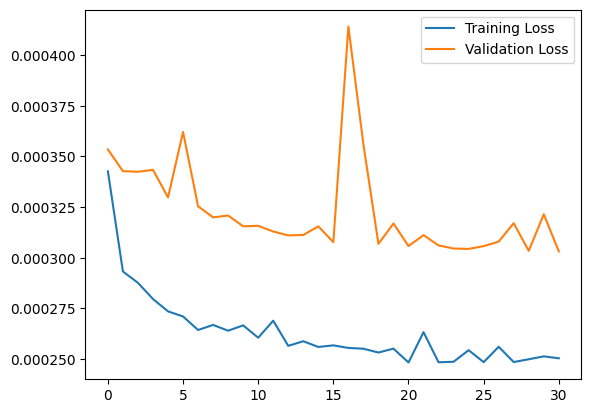

In [19]:
history.history['loss']

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [20]:
# history.history['loss']

In [21]:
predicted = narxffn_model(x)

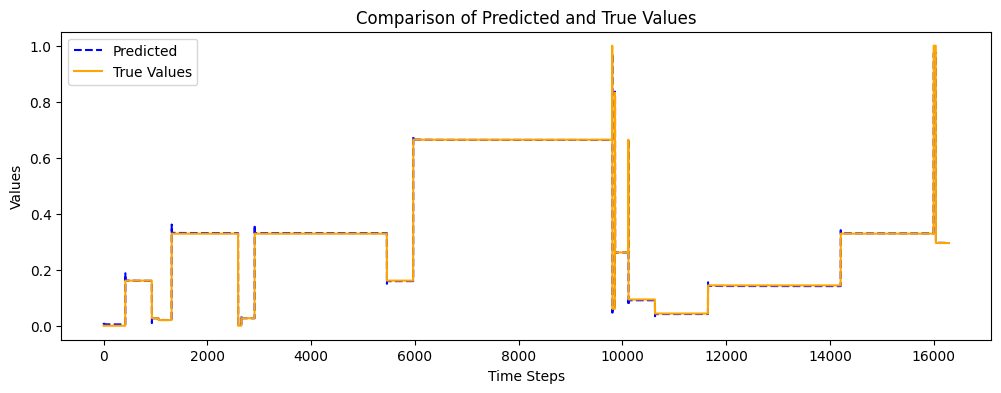

In [22]:
# Create the figure and set the size
plt.figure(figsize=(12, 4))

# Plot the predicted values
plt.plot(predicted, label="Predicted", color="blue", linestyle="--")

# Plot the true values
plt.plot(y, label="True Values", color="orange", linestyle="-")

# Add a title and labels
plt.title("Comparison of Predicted and True Values")
plt.xlabel("Time Steps")
plt.ylabel("Values")

# Add a legend to distinguish the lines
plt.legend()

# Show the plot
plt.show()


In [23]:
narxffn_model.evaluate(x,y)

510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4276e-04 - mae: 0.0022


[0.000247122545260936, 0.002106020227074623]

In [24]:
# Make predictions
y_prednarxffn = narxffn_model.predict(x_valid)

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


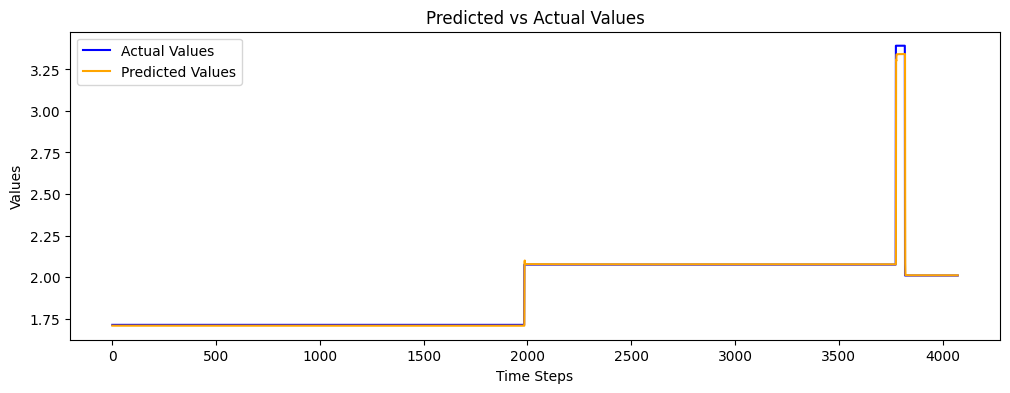

In [25]:
# Reshape y_valid and y_prednarxffn to be 2D arrays
y_valid_reshaped = y_valid.reshape(-1, 1)
y_prednarxffn_reshaped = y_prednarxffn.reshape(-1, 1)

# Rescale back to original values for comparison
y_valid_rescaled = scaler.inverse_transform(
    np.hstack((y_valid_reshaped, np.zeros_like(y_valid_reshaped)))
)
y_prednarxffn_rescaled = scaler.inverse_transform(
    np.hstack((y_prednarxffn_reshaped, np.zeros_like(y_prednarxffn_reshaped)))
)

# Plot predictions vs actuals
plt.figure(figsize=(12, 4))
plt.plot(y_valid_rescaled[:, 0], label="Actual Values", color="blue")
plt.plot(y_prednarxffn_rescaled[:, 0], label="Predicted Values", color="orange")
plt.title("Predicted vs Actual Values")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.show()


### 2. Classical NARXNN Implementation

**Mathematical explanation for the sequence function**

The function `create_narx_sequences` creates overlapping sliding windows from the dataset:

- **Mathematical Explanation:**

Let \( X_t \) represent the input data at time step \( t \), and \( Y_t \) represent the target variable at time step \( t \).

For each sequence, the function creates:
- **AR terms**: \( AR_t = [Y_{t-1}, Y_{t-2}, ..., Y_{t-k}] \) (past values of the target column).
- **Exogenous terms**: \( X_{exog} = [X_{t-1}, X_{t-2}, ..., X_{t-k}] \) (past values of all input variables except the target).

The resulting input for time step \( t \) is:

\[
\text{Input} = [AR_t, X_{exog}]
\]

The target for this input sequence is the future target values over the output lags:

\[
Y_{t+1:t+\text{output\_lags}}
\]

---



In [26]:
def create_narx_sequences(data, target_column, input_lags=3, output_lags=1):
    """
    Generates sequences with explicit autoregressive (AR) terms and exogenous (input) terms for NARXNN 
    (Nonlinear AutoRegressive with eXogenous inputs) models.

    This function creates sequences where the inputs include both past values of the target (AR terms) 
    and past values of all other features (exogenous inputs). The outputs are the future values of the 
    target variable over the specified output lags.

    Parameters:
    ----------
    data : ndarray
        A 2D array containing the time-series data, where each row represents a time step and each column represents a feature.
        
    target_column : int
        The column index of the target variable for prediction.

    input_lags : int, optional (default=3)
        The number of past time steps to include in the input sequence for both AR and exogenous terms.

    output_lags : int, optional (default=1)
        The number of future time steps for which predictions are made.

    Returns:
    -------
    np.ndarray, np.ndarray
        A tuple containing:
        - The first array contains the input sequences (with both AR and exogenous inputs).
        - The second array contains the future target values (over `output_lags` time steps).

    Mathematical Explanation:
    -------------------------
    Let \( X_t \) represent the input data at time step \( t \), and \( Y_t \) represent the target variable at time step \( t \).
    For each sequence, the function creates:
    - AR terms: \( AR_t = [Y_{t-1}, Y_{t-2}, ..., Y_{t-k}] \) (past values of the target column).
    - Exogenous terms: \( X_{exog} = [X_{t-1}, X_{t-2}, ..., X_{t-k}] \) (past values of all input variables except the target).

    The resulting input for time step \( t \) is: 
        \( Input = [AR_t, X_{exog}] \)

    The target for this input sequence is the future target values over the output lags:
        \( Y_{t+1:t+output\_lags} \)

    Example:
    --------
    data = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])
    target_column = 1
    input_lags = 2
    output_lags = 1
    sequences, labels = create_narx_sequences(data, target_column, input_lags=input_lags, output_lags=output_lags)
    """
    inputs, targets = [], []
    n_samples = len(data)

    for i in range(input_lags, n_samples - output_lags):
        # AR terms (past values of the target)
        ar_terms = data[i - input_lags:i, target_column]
        
        # Exogenous terms (past values of the other input variables)
        exog_terms = data[i - input_lags:i, :]
        
        # Concatenate AR terms and exogenous terms
        # inputs.append(np.hstack([ar_terms, exog_terms.flatten()]))
        combined = np.hstack([ar_terms.reshape(-1, 1), exog_terms])
        inputs.append(combined)  # Keep shape as (input_lags, features)
        
        # Future target values for output lags
        targets.append(data[i:i + output_lags, target_column])
    
    return np.array(inputs), np.array(targets)


<>:2: SyntaxWarning: invalid escape sequence '\('
<>:2: SyntaxWarning: invalid escape sequence '\('
C:\Users\onyer\AppData\Local\Temp\ipykernel_20600\1748450969.py:2: SyntaxWarning: invalid escape sequence '\('
  """


In [27]:
# Define target (e.g., 'V' column as the target variable)
target_column = 0  # 'V' is the first column
input_lags = 3  # Number of past steps to include
output_lags = 1  # Predict one step ahead

x, y = create_narx_sequences(scaled_data.to_numpy(), target_column, input_lags, output_lags)

In [28]:
# Train-test split
split_ratio = 0.25
split = int(len(x) * (1 - split_ratio))
x_train, x_valid = x[:split], x[split:]
y_train, y_valid = y[:split], y[split:]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")

x_train shape: (12221, 3, 3), y_train shape: (12221, 1)
x_valid shape: (4074, 3, 3), y_valid shape: (4074, 1)


In [29]:
# Check shapes after fixing
print(f"x_train shape: {x_train.shape}")  # Expected: (samples, timesteps, features)
print(f"y_train shape: {y_train.shape}")  # Expected: (samples, output_lags)

x_train shape: (12221, 3, 3)
y_train shape: (12221, 1)


## **NARXNN (Nonlinear Autoregressive with Exogenous Inputs Neural Network with LSTM)**

The **NARXNN** model uses a more sophisticated architecture with an **LSTM (Long Short-Term Memory)** layer to capture sequential dependencies in the time-series data, which is especially useful for time-series forecasting problems.

### **Model Architecture**

```python
narx_model = keras.Sequential([
    layers.LSTM(32, activation='tanh', input_shape=(x_train.shape[1], x_train.shape[2])),
    layers.Dense(16, activation='tanh'),
    layers.Dense(y_train.shape[1], activation='relu')  # Output layer
])
```

- **LSTM Layer (32 units)**:
    - The first layer is an **LSTM** layer with **32 units**. LSTMs are a type of recurrent neural network (RNN) specifically designed to learn long-term dependencies in sequential data.
    - The **activation function** used here is **'tanh'**, which helps capture the nonlinear relationships in the sequential data.
    - The **input shape** is specified as `(x_train.shape[1], x_train.shape[2])`, which represents the number of time steps and the number of features (exogenous inputs) at each time step.

- **Hidden Dense Layer**:
    - A **Dense** layer with **16 units**, using the **'tanh'** activation function. This layer further processes the output of the LSTM layer to capture more complex relationships between the sequence and the target variable.

- **Output Layer**:
    - The final **Dense** layer outputs the predicted values, with the number of units matching the shape of the target variable (`y_train.shape[1]`), and uses the **'relu'** activation function. This activation ensures that the predicted values are non-negative and are appropriate for regression tasks.

### **Model Compilation**

```python
narx_model.compile(
    optimizer=keras.optimizers.Adam(), 
    loss='mse', 
    metrics=['mae']
    )
```

- **Optimizer**: **Adam** is used as the optimizer, known for its efficiency in training neural networks by adjusting the weights through adaptive learning rates.
- **Loss Function**: **Mean Squared Error (MSE)** is the loss function, which penalizes large deviations between the predicted and actual target values.
- **Metrics**: **Mean Absolute Error (MAE)** is used as a metric, providing an average of the absolute errors, which is useful for evaluating the prediction quality.

---

In [30]:
# Define the NARXNN model
narx_model = keras.Sequential([
    layers.LSTM(32, activation='tanh', input_shape=(x_train.shape[1], x_train.shape[2])),
    layers.Dense(16, activation='tanh'),
    layers.Dense(y_train.shape[1], activation='relu')  # Output layer
])

# Compile the model
narx_model.compile(
    optimizer=keras.optimizers.Adam(), 
    loss='mse', 
    metrics=['mae']
    )


c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
# Train the model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [32]:
history = narx_model.fit(
    x_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(x_valid, y_valid),
    callbacks=[callback],
    verbose=1
)


Epoch 1/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0205 - mae: 0.0712 - val_loss: 3.3733e-04 - val_mae: 0.0110
Epoch 2/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8943e-04 - mae: 0.0082 - val_loss: 2.2346e-04 - val_mae: 0.0028
Epoch 3/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2711e-04 - mae: 0.0037 - val_loss: 2.1558e-04 - val_mae: 0.0027
Epoch 4/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8161e-04 - mae: 0.0039 - val_loss: 2.1192e-04 - val_mae: 0.0031
Epoch 5/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9048e-04 - mae: 0.0042 - val_loss: 2.6640e-04 - val_mae: 0.0084
Epoch 6/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7235e-04 - mae: 0.0048 - val_loss: 2.0002e-04 - val_mae: 0.0036
Epoch 7/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7307e-04 - mae: 0.0051 - val_loss: 1.9403e-04 - val_mae: 0.0028
Epoch 8/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1446e-04 - mae: 0.0043 - val_loss: 1.8278e-04 - val_

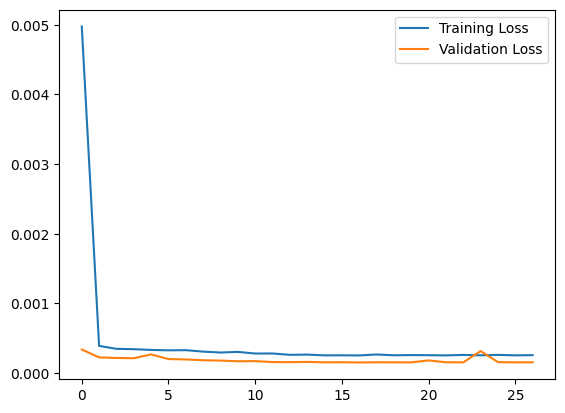

In [33]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [34]:
predicted = narx_model(x)

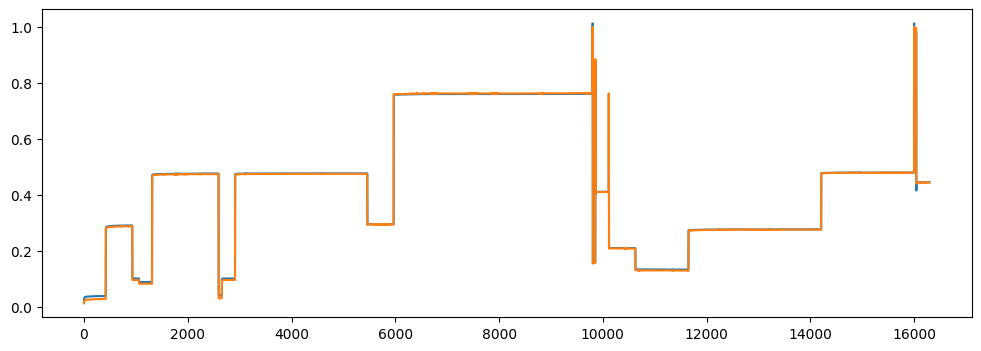

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(predicted)
plt.plot(y)

In [36]:
# Make predictions
y_prednarx = narx_model.predict(x_valid)

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


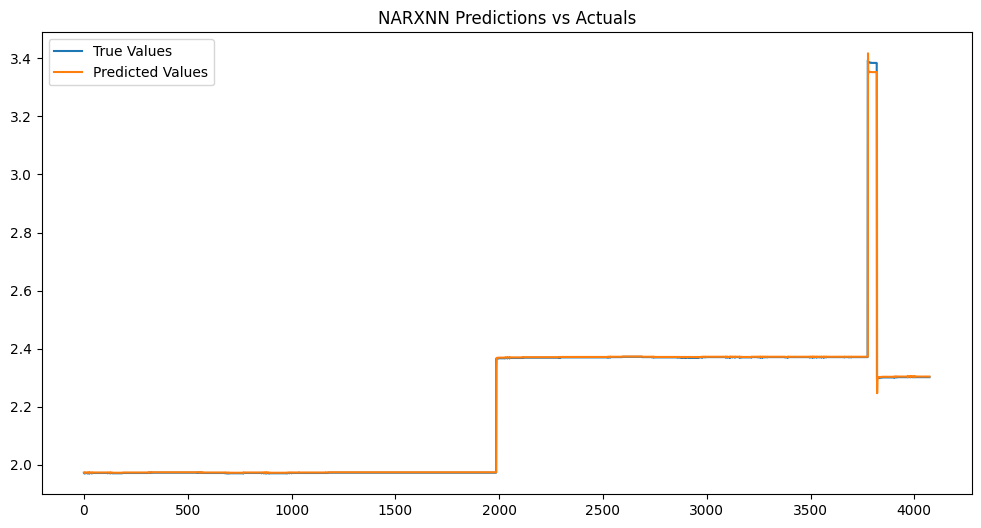

In [37]:
# Rescale back to original values for comparison
y_valid_rescaled = scaler.inverse_transform(np.hstack((y_valid, np.zeros_like(y_valid))))
y_prednarx_rescaled = scaler.inverse_transform(np.hstack((y_prednarx, np.zeros_like(y_prednarx))))

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(y_valid_rescaled[:, 0], label='True Values')
plt.plot(y_prednarx_rescaled[:, 0], label='Predicted Values')
plt.legend()
plt.title('NARXNN Predictions vs Actuals')
plt.show()

### Model Comparison

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For FNN
mae_fnn = mean_absolute_error(y_valid_rescaled[:, 0], y_prednarxffn_rescaled[:, 0])
mse_fnn = mean_squared_error(y_valid_rescaled[:, 0], y_prednarxffn_rescaled[:, 0])

# For NARXNN
mae_narx = mean_absolute_error(y_valid_rescaled[:, 0], y_prednarx_rescaled[:, 0])
mse_narx = mean_squared_error(y_valid_rescaled[:, 0], y_prednarx_rescaled[:, 0])

# Print results
print(f"FNN - MAE: {mae_fnn}, MSE: {mse_fnn}")
print(f"NARXNN - MAE: {mae_narx}, MSE: {mse_narx}")

# Metrics (MAE, MSE): Which model has the lowest errors? Classical NARXNN?


FNN - MAE: 0.27707879874609115, MSE: 0.07755932058429489
NARXNN - MAE: 0.0025098419067727854, MSE: 0.0005811847947454203



### **Key Differences Between NARXFFN and NARXNN Models**

- **Architecture**: 
    - **NARXFFN** is a simple feedforward neural network with a dense architecture, whereas **NARXNN** uses an LSTM layer to capture sequential dependencies in time-series data.
    - The **NARXNN** model is more complex and better suited for tasks where the target variable is influenced by past time steps (time-series forecasting).

- **Sequence Modeling**: 
    - **NARXNN** is more suitable for handling sequential data, making it better at capturing long-term dependencies and patterns in time-series data. The **LSTM** layer in this model helps address issues like vanishing gradients, which can occur in traditional RNNs.
    - **NARXFFN**, on the other hand, is a simpler model that may be effective for relatively straightforward problems where past values and external inputs are sufficient for prediction.

- **Performance**:
    - **NARXNN** is expected to perform better in time-series forecasting tasks, especially when there are long-term dependencies in the data.
    - **NARXFFN** might be faster to train and simpler to implement but might not capture complex temporal dependencies as effectively as the **NARXNN**.

---